In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 
from PIL import Image 
import time 
from IPython import display

%matplotlib inline 

import utils as utils

tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

# Residual Network Development & Testing 

Resisual networks feature skip-forward connections.  [This paper](https://web.stanford.edu/class/cs331b/2016/projects/zhao.pdf) features successful use of a autoencoder with skip-forward connections.  

In [18]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Activation, Add 
from tensorflow.keras.initializers import glorot_uniform

def ResidualAutoencoderV2(batch_size=32): 
    """ returns a keras model"""
    
    input_shape = (64, 64, 1)
    img_input = Input(shape=input_shape)


    ## Downsampling  
    x = img_input
    x = Conv2D(filters=64, kernel_size=(4, 4), padding='same', kernel_initializer=glorot_uniform(seed=0))(x)
    x = Activation('relu')(x) 
    
    shortcut_1 = x 
    x = Conv2D(filters=64, kernel_size=(8, 8), strides=(2, 2), padding='same', 
               kernel_initializer=glorot_uniform(seed=0))(x)
    x = Activation('relu')(x) 
    
    shortcut_2 = x 
    x = Conv2D(filters=128, kernel_size=(8, 8), strides=(2, 2), padding='same', 
               kernel_initializer=glorot_uniform(seed=0))(x)
    x = Activation('relu')(x) 
    
    shortcut_3 = x     
    x = Conv2D(filters=256, kernel_size=(8, 8), strides=(2, 2), padding='same', 
               kernel_initializer=glorot_uniform(seed=0))(x)
    x = Activation('relu')(x) 

    shortcut_4 = x 
    x = Conv2D(filters=518, kernel_size=(4, 4), strides=(2, 2), padding='same', 
               kernel_initializer=glorot_uniform(seed=0))(x)
    x = Activation('relu')(x) 


    
    ## Upsampling 
    x = Conv2DTranspose(filters=256, kernel_size=4, strides=(2, 2), padding='same')(x) 
    x = Activation('relu')(x) 

    x = Add()([x, shortcut_4]) 
    x = Conv2DTranspose(filters=128, kernel_size=8, strides=(2, 2), padding='same')(x)
    x = Activation('relu')(x) 

    x = Add()([x, shortcut_3]) 
    x = Conv2DTranspose(filters=64, kernel_size=16, strides=(2, 2), padding='same')(x)
    x = Activation('relu')(x) 

    x = Add()([x, shortcut_2]) 
    x = Conv2DTranspose(filters=64, kernel_size=16, strides=(2, 2), padding='same')(x)
    x = Activation('relu')(x) 

    x = Add()([x, shortcut_1])
    x = Conv2DTranspose(filters=1, kernel_size=64, padding='same')(x)    

    return tf.keras.Model(img_input, x, name='res_autoencoder_v2')
    

In [19]:
model = ResidualAutoencoderV2()
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

## Dataset preparation 

In [20]:
BATCH_SIZE = 32 
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 8    # Shuffle the training data by a chunck of this many observations

filenames = utils.get_filenames_list('data/dataset64-easy-snp/')
train_ds = utils.create_dataset(filenames, SHUFFLE_BUFFER_SIZE, AUTOTUNE, BATCH_SIZE)

## Train 

In [38]:
history = model.fit(train_ds, epochs=150)

Epoch 1/150
50/50 [==============================] - 5s 99ms/step - loss: 0.0055 - accuracy: 0.0458
Epoch 2/150
50/50 [==============================] - 5s 99ms/step - loss: 0.0054 - accuracy: 0.0458
Epoch 3/150
50/50 [==============================] - 5s 100ms/step - loss: 0.0053 - accuracy: 0.0458
Epoch 4/150
50/50 [==============================] - 5s 101ms/step - loss: 0.0051 - accuracy: 0.0458
Epoch 5/150
50/50 [==============================] - 5s 101ms/step - loss: 0.0050 - accuracy: 0.0458
Epoch 6/150
50/50 [==============================] - 5s 102ms/step - loss: 0.0049 - accuracy: 0.0458
Epoch 7/150
50/50 [==============================] - 5s 103ms/step - loss: 0.0048 - accuracy: 0.0458
Epoch 8/150
50/50 [==============================] - 5s 102ms/step - loss: 0.0048 - accuracy: 0.0458
Epoch 9/150
50/50 [==============================] - 5s 103ms/step - loss: 0.0047 - accuracy: 0.0458
Epoch 10/150
50/50 [==============================] - 5s 102ms/step - loss: 0.0046 - accuracy

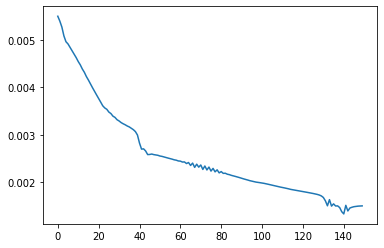

In [39]:
x_ = np.arange(0, 150)  
y_ = history.history['loss']  

plt.plot(x_, y_)

# Testing 
Take and image, pass through network.

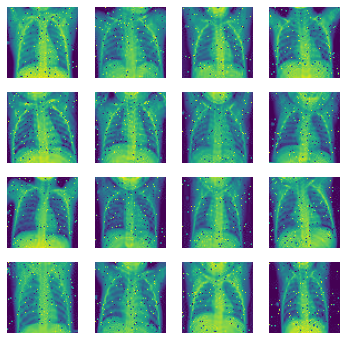

In [40]:
for i in train_ds.take(1): 
    ims = i[0]
    orgs = i[1]
    
fig, ax = plt.subplots(4, 4, figsize=(6, 6))
ax = ax.reshape(-1) 

for i, ax in enumerate(ax): 
    ax.imshow(np.squeeze(ims[i]))
    ax.axis(False)

In [31]:
preds = model.predict(ims)

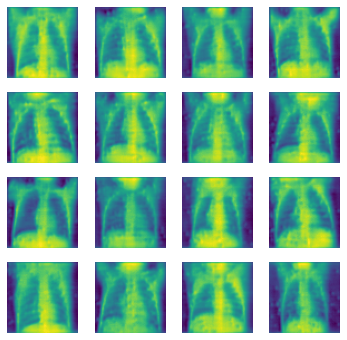

In [41]:
fig, ax = plt.subplots(4, 4, figsize=(6, 6))
ax = ax.reshape(-1)

for i, ax in enumerate(ax):
    ax.imshow(np.squeeze(preds[i]))
    ax.axis(False)

Text(0.5, 1.0, 'Original')

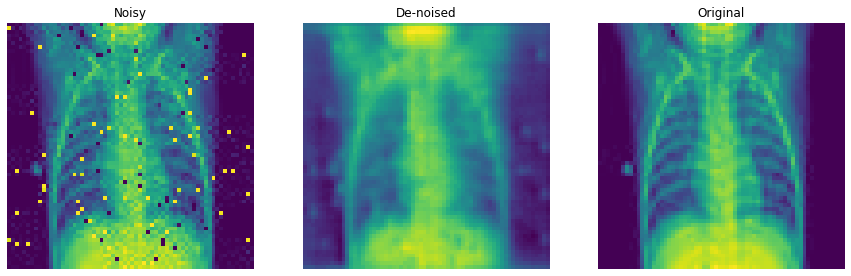

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
i = 15

axes[0].imshow(np.squeeze(ims[i]))
axes[0].axis(False)
axes[0].set_title('Noisy')

axes[1].imshow(np.squeeze(preds[i]))
axes[1].axis(False)
axes[1].set_title('De-noised')

axes[2].imshow(np.squeeze(orgs[i]))
axes[2].axis(False)
axes[2].set_title('Original')


In [43]:
model.save('2021')

INFO:tensorflow:Assets written to: 2021/assets


In [45]:
!zip -r /content/2021.zip /content/2021

  adding: content/2021/ (stored 0%)
  adding: content/2021/saved_model.pb (deflated 91%)
  adding: content/2021/assets/ (stored 0%)
  adding: content/2021/variables/ (stored 0%)
  adding: content/2021/variables/variables.index (deflated 72%)
  adding: content/2021/variables/variables.data-00000-of-00001 (deflated 37%)
